# The Wonderful World of Coffee
### Business Understanding
This notebook begins to explore a coffee dataset that has been scraped by a reddit user from the Coffee Quality
 Institute's website and uploaded onto GitHub.  Our idea behind researching this dataset is to identify where the top
coffee brands come from, and what attributes go into the production of that coffee that makes it so desirable?
Can a model be built targeting those ranges of successful coffee producers in order to predict ratings for 
their future brands?  These are some of the questions we will investigate in our first project.

The data source for our dataset:

https://github.com/jldbc/coffee-quality-database

### Data Description (Meaning/Type/Quality)
Lets import our libraries and data. 


In [23]:
#Add library references
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [24]:
#Upload Data
df_ar = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv',
                    sep=',', header=0) # read in the arabicaica data
df_rob = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/robusta_data_cleaned.csv',
                     sep=',', header=0) # read in the Robusta data
#Column rename to match for merging
df_ar.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
df_rob.rename(columns={'Unnamed: 0':'Id',
                       'Bitter...Sweet':'Sweetness',
                       'Uniform.Cup':'Uniformity',
                       'Salt...Acid':'Acidity',
                       'Fragrance...Aroma':'Aroma'}, inplace=True)


## Data meaning

Below is a list of continuous and categorical measures:
#### Continuous (Quality) Measures
* Aroma  
* Flavor
* Aftertaste
* Acidity
* Body
* Balance
* Uniformity
* Cup Cleanliness
* Sweetness
* Moisture
* Defects
* Cupper Points
* Total Cup Points

#### Categorical (Bean) Measures
* Processing Method
* Color
* Species (arabica / robusta)

#### Categorical (Farm) Measures
* Owner
* Country of Origin
* Farm Name
* Lot Number
* Mill
* Company
* Altitude
* Region

Since the data came to us in two CSV's of arabica and robusta, lets combine the two datasets to begin our analysis.  First we'll need to remove 
a few columns and merge the two dataframes.

In [25]:

#dropping columns we won't use
df_rob = df_rob.drop(['Lot.Number', 'altitude_low_meters', 'altitude_high_meters', 'Certification.Contact',
                      'Certification.Contact', 'Expiration', 'Certification.Body', 'ICO.Number',
                      'Certification.Address','Mouthfeel', 'Id'], axis=1)
df_ar = df_ar.drop(['Lot.Number', 'altitude_low_meters', 'altitude_high_meters', 'Certification.Contact',
                      'Certification.Contact', 'Expiration', 'Certification.Body', 'ICO.Number',
                      'Certification.Address', 'Id'], axis=1)

df_comb = df_ar.append(df_rob)


C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Data Quality & Simple Statistics
Now that our dataframes are combined, lets analyze counts of missing values and simple statistics.
#### Missing Values
The majority of missing values center around farm name, mill, producer, altitude, company.  At this stage, we need
to decide what categorical values we can keep for regional analysis.  Currently its looking like country might be one
of the better attributes to start an analysis.  Luckily, the continuous data has very low NA counts which means any 
regression, will likely fair well.  Yet with the categorical attributes missing a fair amount of data.  Using them 
for classification analysis might be difficult without sacrificing data integrity.  

In [26]:
print("Structure of data:\n",df_comb.shape,"\n")
print("Count of missing values:\n",df_comb.isnull().sum().sort_values(ascending=False),"\n")



Structure of data:
 (1339, 35) 

Count of missing values:
 Farm.Name               359
Mill                    318
Producer                232
altitude_mean_meters    230
Variety                 226
Altitude                226
Color                   218
Company                 209
Processing.Method       170
Region                   59
Harvest.Year             47
Body                     28
Owner.1                   7
Owner                     7
Quakers                   1
Country.of.Origin         1
Balance                   0
Category.One.Defects      0
Bag.Weight                0
Category.Two.Defects      0
Clean.Cup                 0
Aroma                     0
Aftertaste                0
unit_of_measurement       0
Cupper.Points             0
Flavor                    0
Grading.Date              0
In.Country.Partner        0
Moisture                  0
Number.of.Bags            0
Species                   0
Sweetness                 0
Total.Cup.Points          0
Uniformity       

### Simple Statistics
As any good Data Scientist, we first must check our data ranges, means, max's, mins, and quartiles, to see where
the data sits.  Our continuous variables operate on a scale from 1 to 10, meaning most values
won't need to be imputed.  Any, that are, can easily be dropped without effecting the sample size.


In [27]:
#Simple Stats
# print(df_comb.head().append(df_comb.tail()), "\n")
print("Summary Statistic's:\n",round(df_comb.describe(),2),"\n")


Summary Statistic's:
        Acidity  Aftertaste    Aroma  Balance     Body  Category.One.Defects  \
count  1339.00     1339.00  1339.00  1339.00  1311.00               1339.00   
mean      7.54        7.40     7.57     7.52     7.52                  0.48   
std       0.38        0.40     0.38     0.41     0.36                  2.55   
min       0.00        0.00     0.00     0.00     0.00                  0.00   
25%       7.33        7.25     7.42     7.33     7.33                  0.00   
50%       7.58        7.42     7.58     7.50     7.50                  0.00   
75%       7.75        7.58     7.75     7.75     7.67                  0.00   
max       8.75        8.67     8.75     8.75     8.58                 63.00   

       Category.Two.Defects  Clean.Cup  Cupper.Points   Flavor  Moisture  \
count               1339.00    1339.00        1339.00  1339.00   1339.00   
mean                   3.56       9.84           7.50     7.52      0.09   
std                    5.31       0.76

Looking through the statistics we find a few outliers in the altitude mean category so we replaced them with an Na and then imputed the 
rest of the NA's for altitude with the mean of the attribute. We also removed a row that didn't have a country
of origin.  Most of the other simple statistics seem to be in their appropriate ranges for what we expect on the continuous
variables.

In [28]:
#Changing datatypes
conv_dict = {'Species': str,
                'Owner': str,
                'Mill': str,
                'Company': str,
                'Region': str,
                'Producer': str,
                'Variety': str
                }
df_comb = df_comb.astype(conv_dict)
#Outlier Removal altitude
df_comb.loc[[896,1040,1144,543],'altitude_mean_meters'] = np.nan
df_comb['altitude_mean_meters'].fillna((df_comb['altitude_mean_meters'].mean()),inplace=True)
#nan removal from country
df_comb = df_comb.drop(df_comb.index[1197])



### Visualize Attributes
Now that we've got our data organized and a little cleaner, lets begin visualizing our data. We'll start with a 
bar chart of the Number of coffee samples by Country.


Text(0.5, 1.0, 'Number of Coffee Samples by Country')

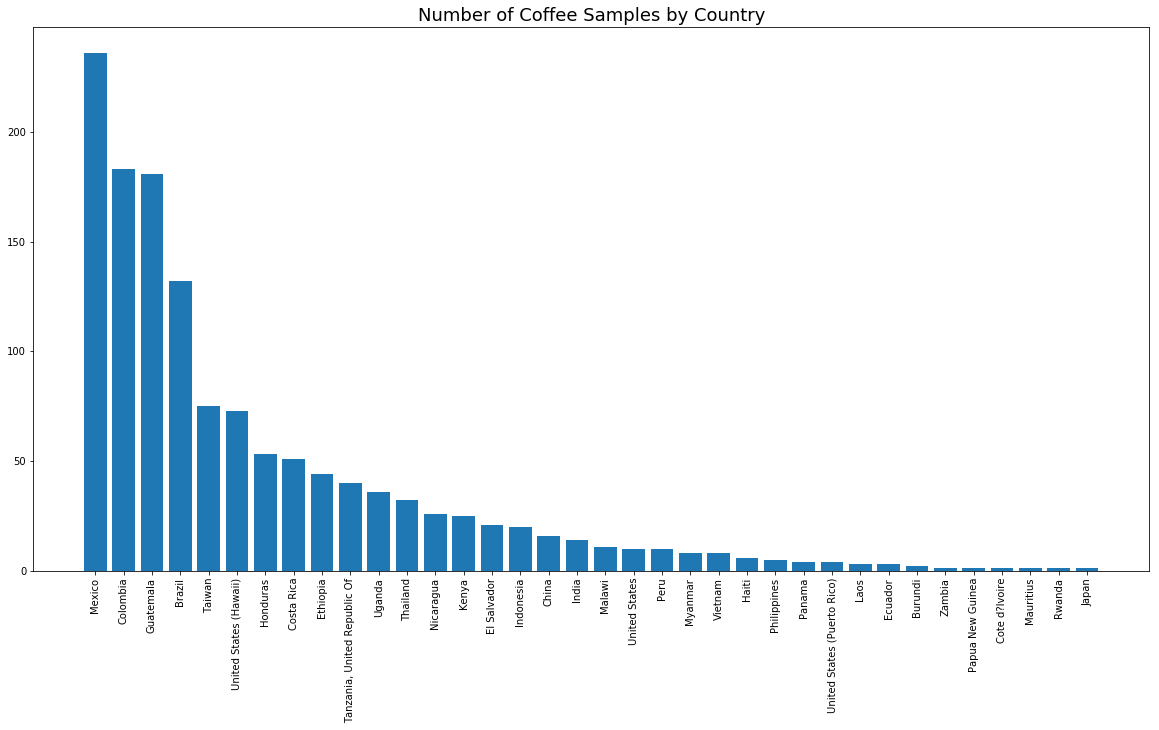

In [29]:
counts = df_comb['Country.of.Origin'].value_counts().to_dict()
min_count = min(counts.values())
max_count = max(counts.values())

#Bar graph of number of coffee samples per country, top 50
counts_top50 = dict(list(counts.items())[int(len(counts)/2):])
plt.figure(figsize=(20,10))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.title("Number of Coffee Samples by Country", fontsize='18')

With Mexico coming in first, we're not surprised by those that follow it.  Columbia, Guatamala, Brazil, Taiwan are
all excellent climates for growing coffee beans.  This matches with common knowledge of larger coffee producing
countries.  Another interesting side-note is that Hawaii produces 3x as many coffee varieties as the mainland US.  


Now that we've got an idea behind who are the biggest producers, lets see who produces some of the better brands 
via the reviewers "Total Cup Score."  We'll group by country and analyze their average score.

In [30]:
#Dataframe of countries by avg Cup rating

country_lists=list(df_comb['Country.of.Origin'].unique())
country_total_cup_ratio=[]
for each in country_lists:
    country=df_comb[df_comb['Country.of.Origin']==each]
    country_total_cup_avg=round(sum(country['Total.Cup.Points'])/len(country),2)
    country_total_cup_ratio.append(country_total_cup_avg)

    
data=pd.DataFrame({'Country of Origin':country_lists,'Total Cup Avg':country_total_cup_ratio})
new_index=(data['Total Cup Avg'].sort_values(ascending=False)).index.values
sorted_data = data.reindex(new_index)
sorted_data.head(10)


,Country of Origin,Total Cup Avg
19,Papua New Guinea,85.75
0,Ethiopia,85.48
21,Japan,84.67
4,United States,84.43
15,Kenya,84.31
18,Panama,83.71
10,Uganda,83.45
17,Colombia,83.11
20,El Salvador,83.05
7,China,82.93


Here we see a few differing results as alot of the central american countries are lower than expected in 
terms of overall coffee rating.  The best coffee it would seem comes from Papua New Guinea, Ethiopia, and Japan, 
and the United States.  

Now that we've got a few countries of interest, lets delve into the continuous variables themselves to get an 
idea behind their distributions.  So first a frequency plot of the continuous variables we initially predict to 
be relevant.  We'll also do a pairplot to view some scatterplots of the same variables.


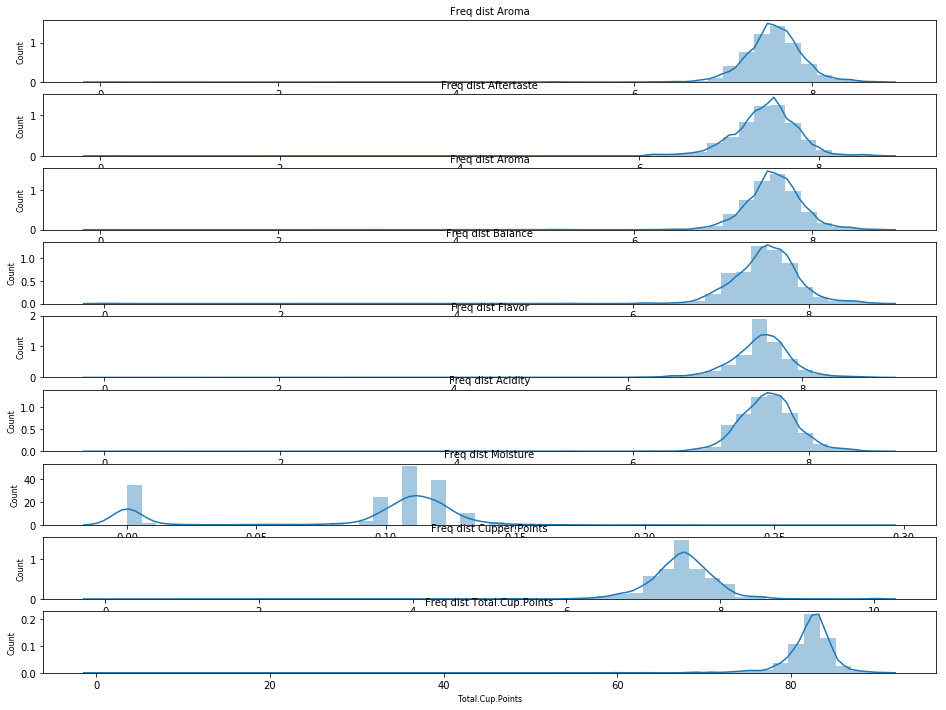

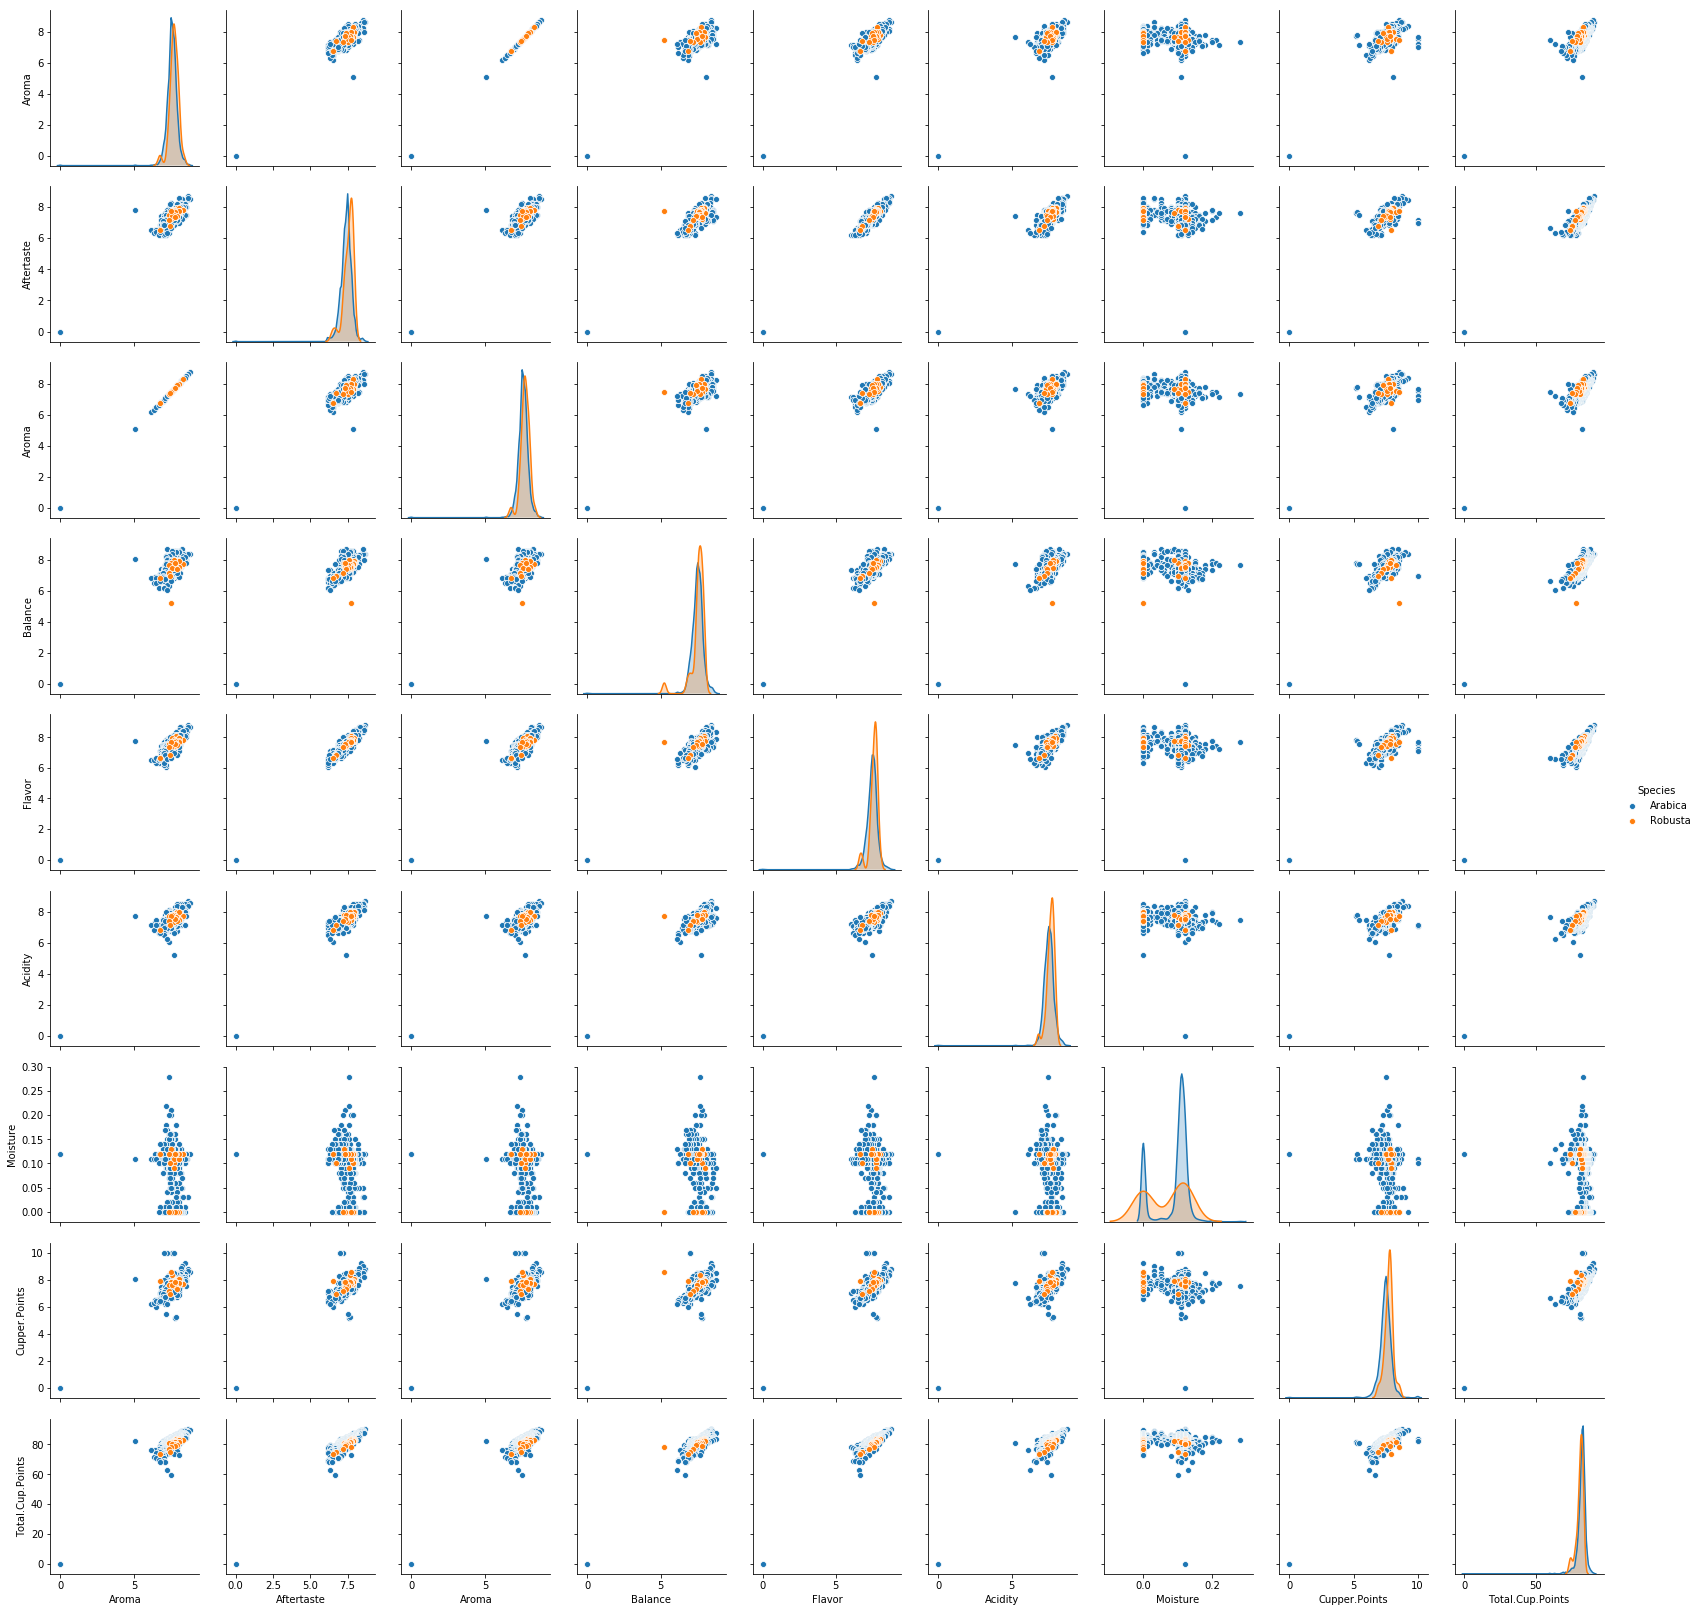

In [31]:
#some initial plots 
col_names = ['Aroma','Aftertaste', 'Aroma','Balance', 
             'Flavor', 'Acidity','Moisture', 'Cupper.Points', 'Total.Cup.Points']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(df_comb[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

# #Huge pairplot matrix.  Probably need to whittle down the attributes a bit first.Example drops below
sns.pairplot(df_comb, vars = ['Aroma','Aftertaste', 'Aroma','Balance', 
             'Flavor', 'Acidity','Moisture', 'Cupper.Points', 'Total.Cup.Points'],
             hue = 'Species');

Now that we've got a better higher level view of the data, we begin to see clustering in the continuous
variables around the 6 to 9 rating mark.  Add to that our range for the rating scale is 1 to 10 and we begin to see
some problems with our dataset.  Mainly since our variables have a very similar distribution, we could end up with
a highly correlated dataset.  So our next step is to look at some individual histograms and
a correlation heat map to confirm our suspicions.

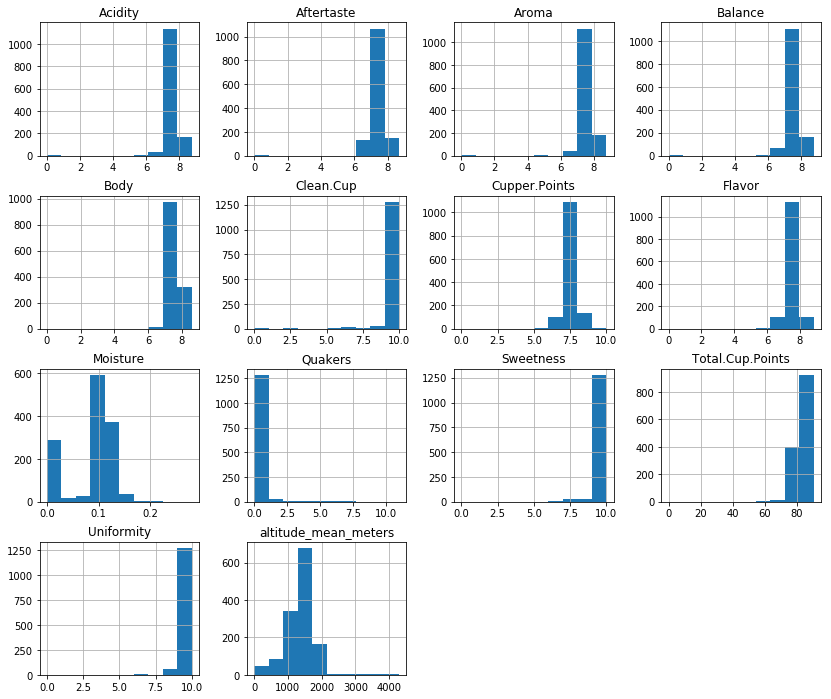

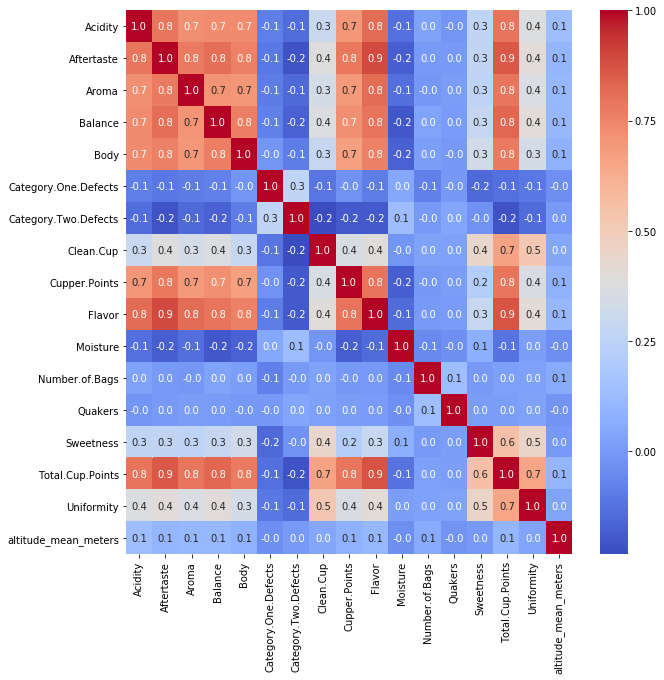

In [32]:
df_num = df_comb.select_dtypes(include=['float64'])
df_num.hist(figsize =(14,12))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
corr = df_comb.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".1f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

There is some correlation to be concerned with, but for now lets just keep it in mind.
hey wait a minute

